```
This file is part of connectome-manipulator.

SPDX-License-Identifier: Apache-2.0
Copyright (c) 2024 Blue Brain Project/EPFL
```

# Adjacency matrix rewiring example

Working example to rewire the connectivity among EXC neurons based on an arbitrary adjacency matrix.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from bluepysnap import Circuit, Simulation
from connectome_manipulator.connectome_comparison import adjacency
from connectome_manipulator.model_building import model_types
from scipy.sparse import coo_matrix

In [27]:
# Some helper functions
def plot_nodes(nodes, **kwargs):
    """ Plot neuron positions in 3D space by layer. """
    defargs = dict(marker='.', markeredgewidth=0, markersize=3, alpha=1.0)
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 1, 1, projection='3d')
    for _lay in list(nodes.property_values('layer')):
        pos = nodes.get({'layer': _lay}, properties=['x', 'y', 'z'])
        plt.plot(pos['x'], pos['y'], pos['z'], **(defargs | kwargs), lw=0, label=f'L{_lay}')
    plt.gca().set_xlabel('x (um)')
    plt.gca().set_ylabel('y (um)')
    plt.gca().set_zlabel('z (um)')
    plt.axis('equal')
    plt.gca().view_init(elev=10, azim=45, roll=0)
    plt.legend(loc='upper left', bbox_to_anchor=[1.0, 0.75])
    plt.tight_layout()
    plt.show()

def plot_adj(adj, **kwargs):
    """ Plot adjacency matrix in COO format."""
    defargs = dict(color='k', marker='.', s=3, edgecolors='none', alpha=0.5)
    plt.figure(figsize=(3, 3))
    plt.scatter(adj.col, adj.row, **(defargs | kwargs))
    plt.axis('image')
    plt.gca().invert_yaxis()
    plt.xlabel('Post-synaptic neurons')
    plt.ylabel('Pre-synaptic neurons')
    plt.tight_layout()
    plt.show()

def plot_img(fn, figsize=(5, 3)):
    img = plt.imread(fn)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## Download example circuit

Download and uncompress the SONATA toy circuit from ZENODO (DOI [10.5281/zenodo.12202780](https://doi.org/10.5281/zenodo.12202780)), or use any other network model in SONATA format. Set path to circuit config below.

In [3]:
# Path to SONATA circuit config
circuit_config = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/ToyCircuit-S1-6k/circuit_config.json'

## Model building

Before we can run rewiring, we need to define the new connectivity given as an adjacency matrix, as well as stochastic model descriptions for physiological parameters which we will fit against the existing connectome.

### Step 1: Load circuit and extract adjacency matrix

In [4]:
# Load circuit
c = Circuit(circuit_config)
nodes = c.nodes['All']
edges = c.edges['default']
print(f'Loaded circuit with {nodes.size} neurons and {edges.size} synapses')

Loaded circuit with 5924 neurons and 568717 synapses


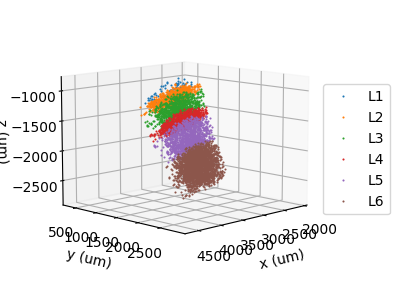

In [5]:
# Plot neuron positions by layer
plot_nodes(nodes)

In [6]:
# Extract adjacency matrix among EXC neurons
adj_dict = adjacency.compute(c, sel_src={'synapse_class': 'EXC'}, sel_dest={'synapse_class': 'EXC'})
adj_ee = adj_dict['adj']['data'].tocoo()
display(adj_ee)

INFO: Creating 5236x5236 adjacency matrix (sel_src={'synapse_class': 'EXC'}, sel_dest={'synapse_class': 'EXC'})


<5236x5236 sparse matrix of type '<class 'numpy.bool_'>'
	with 109234 stored elements in COOrdinate format>

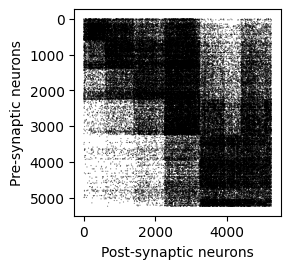

In [7]:
# Plot original adjacency matrix
plot_adj(adj_ee)

### Step 2: Define manipulated adjacency matrix

We just generate a random connectivity matrix with the same number of connections. Any other connectivity matrix could be specified here very easily.

In [8]:
# Random matrix with same number of connections
np.random.seed(0)
adj_manip = coo_matrix(np.reshape(np.random.permutation(adj_ee.toarray().flatten()), adj_ee.shape))

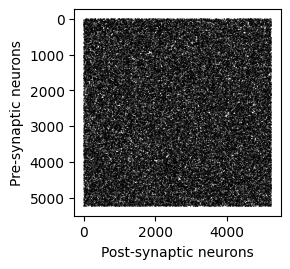

In [9]:
# Plot manipulated adjacency matrix
plot_adj(adj_manip)

### Step 3: Define/fit stochastic models required for rewiring

❗This step is optional: All fitted models are already contained in this repo under `/model_building`.

In [12]:
model_path = './model_building'

__Connectivity model__: Use adjacency matrix from above

In [13]:
# Connectivity model based on manipulated adjacency matrix
adj_model = model_types.LookupTableModel.init_from_sparse_matrix(adj_manip, adj_dict['common']['src_gids'], adj_dict['common']['tgt_gids'])
adj_model.save_model(os.path.join(model_path, 'model'), 'ConnProbAdjModel')
print(adj_model)

LookupTableModel
  <5236x5236 sparse matrix of type '<class 'numpy.bool_'>'
	with 109234 stored elements in Compressed Sparse Column format>
  Value range: True (dtype: bool)


__Axonal delay model for assigning new axonal delays__: Fit axonal delays linearly dependent on Euclidean distance between pre-synaptic neurons and post-synaptic synapse location

❗ Adjust `run_model_building.sh` according to SLURM configuration<br>
❗ Set "working_dir", "out_dir", and "circuit_config" in `model_config__DistDepDelay.json` accordingly

Launch model fitting:

`sbatch run_model_building.sh model_config__DistDepDelay.json --force-reextract --force-rebuild`

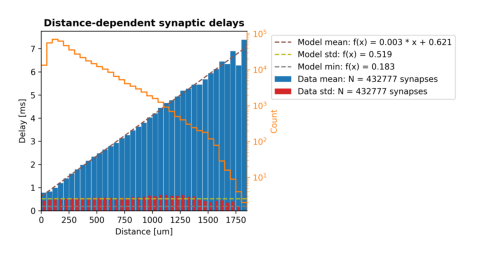

In [28]:
# Visualize model fit
plot_img(os.path.join(model_path, 'output', 'DistDepDelay', 'data_vs_model.png'))

__Properties model for parameterizing new connections/synapses__: Fit pathway-specific parameter distributions

❗ Adjust `run_model_building.sh` according to SLURM configuration<br>
❗ Set "working_dir", "out_dir", and "circuit_config" in `model_config__ConnPropsPerPathway.json` accordingly

Launch model fitting:

`sbatch run_model_building.sh model_config__ConnPropsPerPathway.json --force-reextract --force-rebuild`

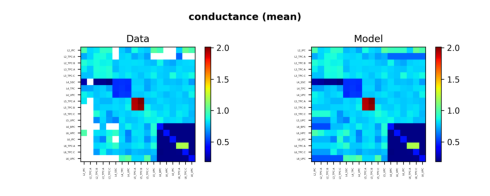

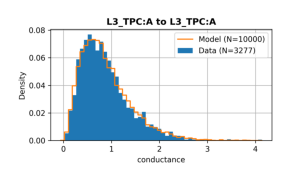

In [33]:
# Visualize model fit (examples)
plot_img(os.path.join(model_path, 'output', 'ConnPropsPerPathway', 'data_vs_model_map_mean__conductance.png'))
plot_img(os.path.join(model_path, 'output', 'ConnPropsPerPathway', 'data_vs_model_hist__conductance.png'), figsize=(3, 2))

## Connectome Manipulation

Setup and run connectome manipulation.

❗ Adjust `run_rewiring_parallel.sh` according to SLURM configuration<br>
❗ Set "circuit_config" and "model_config" in `manip_config__ConnRewire.json` accordingly

Run connectome manipulation using one of the following launch commands:

__Launch command - Serial processing:__

~~~
connectome-manipulator -v manipulate-connectome "manip_config__ConnRewire.json" --output-dir="/gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_AdjRewire" --parallel --profile --convert-to-sonata --splits=500
~~~

❗ Set `output-dir=...` accordingly (must be an absolute path)<br>
❗ `--convert-to-sonata` requires `parquet-converters`

__Launch command - Parallel processing on MPI cluster using SLURM:__

~~~
sbatch run_rewiring_parallel.sh "manip_config__ConnRewire.json" "/gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_AdjRewire" 500
~~~

❗ Adjust `run_rewiring_parallel.sh` according to SLURM configuration<br>
❗ Set output directory accordingly (must be an absolute path)<br>
❗ Requires `parquet-converters` and `mpi4py`


__Output (example):__

~~~
Autoloading python/3.10.8
Autoloading intel-oneapi-mkl/2021.4.0
Autoloading hpe-mpi/2.25.hmpt
Autoloading python/3.10.8
Autoloading hpe-mpi/2.25.hmpt
Autoloading python/3.10.8
Autoloading hpe-mpi/2.25.hmpt
+ srun dplace parallel-manipulator -v manipulate-connectome manip_config__ConnRewire.json --output-dir=/gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_AdjRewire --parallel --profile --convert-to-sonata --splits=500
Dashboard URL: r1i6n8.bbp.epfl.ch:8787
[INFO] Log file "/gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_AdjRewire/logs/connectome_manipulation_2024-06-24_11h50.log" created!
[INFO] Version: connectome_manipulator 0.0.11.dev1
[INFO] Loading circuit from /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/ToyCircuit-S1-6k/circuit_config.json
[INFO] Setting up 500 processing batch jobs...
[INFO] Starting Execution context
[INFO] Start job submission
[INFO] Split 1/500: Wiring connectome targeting 12 neurons
[INFO] Split 2/500: Wiring connectome targeting 12 neurons
...
[INFO] [100%] Finished 500 (out of 500) splits
[INFO] DASK jobs finished
[INFO] Shutting down DASK workers gracefully
[INFO] Done processing
[INFO]   Total input/output synapse counts: 568717/522571 (Diff: -46146)
[INFO] Converting 494 (non-empty) .parquet file(s) to SONATA
[INFO] Deleting 494 temporary .parquet file(s), "_metadata" file, and "parquet.DONE"
[INFO] Creating SONATA config /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_AdjRewire/circuit_config.json
[INFO] +=============================================== PROFILER STATS ===============================================+
[INFO] |                Event Label                 | Min.Time | Avg.Time | Max.Time | Min.Mem  | Avg.Mem  | Max.Mem  |
[INFO] +--------------------------------------------------------------------------------------------------------------+
[INFO] | connectome_manipulation_main               |    26.49 |    26.49 |    26.49 |     0.01 |     0.01 |     0.01 |
[INFO] | processing                                 |     0.30 |     2.99 |     6.12 |     0.00 |     0.01 |     0.02 |
[INFO] |   conn_rewiring                            |     0.29 |     2.94 |     6.09 |     0.00 |     0.01 |     0.02 |
[INFO] |   write_to_parquet                         |     0.00 |     0.01 |     1.03 |     0.00 |     0.00 |     0.00 |
[INFO] +--------------------------------------------------------------------------------------------------------------+
~~~



## Structural comparison

After connectome manipulation, setup and run structural comparison.

### Step 1: Set circuits and paths in structural comparator config

Set the following paths in `structcomp_config__Orig_vs_Manip.json`:
- Under "circuits", set paths to original and manipulated circuit configs.
- Under "working_dir" and "out_dir", set working directory (for cached data) and output directory. Both can be set the same directory.

### Step 2: Configure comparison plots

Under "plot_types" in `structcomp_config__Orig_vs_Manip.json`, the list of comparison plots can be modified. In this example, the following plots are pre-configured:

- "ConnPerLayer_EE": Connection probability and number of synapses per connection between excitatory neurons for all pairs of layers.
- "ConnPerMtype_EE": Connection probability and number of synapses per connection between excitatory neurons for all pairs of m-types.
- "PropsPerMtype_EE": Mean value of selected pyhsiological synapse properties (e.g., conductance, delay, ...) between excitatory neurons for all pairs of m-types.
- "Adjacency": Adjacency matrix between all neurons.

### Step 3: Run structural comparison

❗ Adjust `run_struct_comparison.sh` according to SLURM configuration<br>

__Launch command:__

~~~
sbatch run_struct_comparison.sh structcomp_config__Orig_vs_Manip.json
~~~

__Output (example):__

~~~
VERSION INFO: connectome_manipulator 0.0.11.dev1
INFO: 2 circuits loaded:
  /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/ToyCircuit-S1-6k/circuit_config.json
  /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/circuits/ToyCircuit_AdjRewire/circuit_config.json
INFO: Preparing "ConnPerLayer_EE" plot(s)...
INFO: Computing connectivity (group_by=layer, sel_src={'synapse_class': 'EXC'}, sel_dest={'synapse_class': 'EXC'}, N=6x6 groups)
  0% |                                                                        |
 16% |############                                                            |
 33% |########################                                                |
 50% |####################################                                    |
 66% |################################################                        |
 83% |############################################################            |
100% |########################################################################|
INFO: Writing resutls to /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/rewire_adjacency/struct_comparison/data/Orig_ConnPerLayer_EE.pickle
INFO: Computing connectivity (group_by=layer, sel_src={'synapse_class': 'EXC'}, sel_dest={'synapse_class': 'EXC'}, N=6x6 groups)
  0% |                                                                        |
 16% |############                                                            |
 33% |########################                                                |
 50% |####################################                                    |
 66% |################################################                        |
 83% |############################################################            |
100% |########################################################################|
INFO: Writing resutls to /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/rewire_adjacency/struct_comparison/data/Manip_ConnPerLayer_EE.pickle
INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/rewire_adjacency/struct_comparison/Orig_vs_Manip/struct_comp-ConnPerLayer_EE-nsyn_conn.png...
INFO: Saving /gpfs/bbp.cscs.ch/home/pokorny/git/connectome-manipulator/examples/rewire_adjacency/struct_comparison/Orig_vs_Manip/struct_comp-ConnPerLayer_EE-conn_prob.png...
...
~~~

__Re-plot exemplary results within notebook__

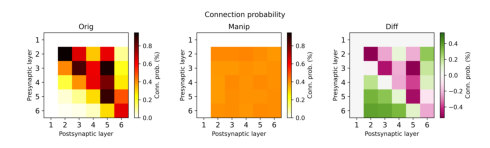

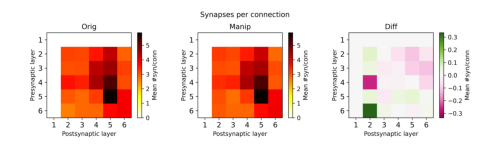

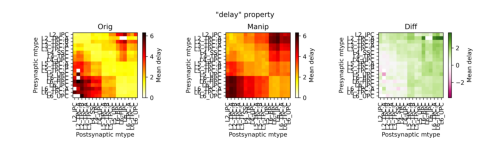

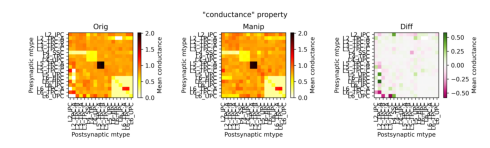

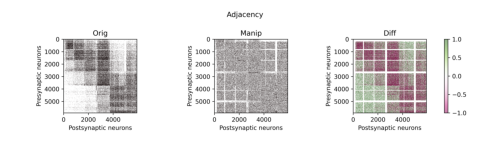

In [39]:
# Visualize structural comparison results (examples)
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-ConnPerLayer_EE-conn_prob.png')
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-ConnPerLayer_EE-nsyn_conn.png')
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-PropsPerMtype_EE-delay.png')
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-PropsPerMtype_EE-conductance.png')
plot_img('./struct_comparison/Orig_vs_Manip/struct_comp-Adjacency-adj.png')  # (Full adjacency - IE, EI, II connections unchanged!)